# 3D Segmentation of Brain Tumor

This document is to propose a 2D methodology instead of treating it as a 3D input.


## Loading the Dataset
The dataset used is the BraTS 2020 Dataset.

The Dataset Contains the Following Scans per case:

T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.

T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.

T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.

FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

So for training T1ce, T2 and FLAIR will be used.

### Importing all dependencies

In [19]:
# Previewing the MRI Data
# TODO: Collect all imports later and add notes next to them
import csv
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from os import path, listdir
import os
from monai.data import Dataset, list_data_collate, DataLoader, decollate_batch
from monai.transforms import (
    LoadImaged,
    Compose,
    MapTransform,
    Orientationd,
    EnsureTyped,
    ToMetaTensord,  # ? same as ensuretyped?
    EnsureChannelFirstd,
    NormalizeIntensityd,
    Spacingd,
    DivisiblePadd,  # ? For UNet needs to be divisible by?
    RandCropByPosNegLabeld,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Activations,
    AsDiscrete,
)

from monai.networks.nets import SegResNet, UNet, UNETR
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss
from monai.metrics import DiceMetric, MeanIoU, compute_meaniou
from monai.inferers import sliding_window_inference

from pytorch_lightning import seed_everything
import torch
from utilities.split_data import train_val_test_dataset

from monai.utils.misc import first

from tqdm import tqdm


c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
seed_everything(1607)

2023-01-19 22:11:40,824 - Global seed set to 1607


1607

In [21]:
import gc

def clear_gpu_cache():
    """Clear the PyTorch GPU Allocation if an OOM error occurs.
    """

    try:
        print("Deleting Model")
        global model
        del model
    except NameError as e:
        print(f"Model Already Cleared")

    print("Collecting Garbage")
    gc.collect()
    print("Clearing CUDA Cache")
    torch.cuda.empty_cache()
    print("Done")


## Preparing the Dataset

As per [University of Pennsylvania](https://www.med.upenn.edu/cbica/brats2020/data.html):

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions, mentioned as data contributors here.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper(opens in a new window) and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., *co-registered to the same anatomical template*, interpolated to the *same resolution (1 mm^3)* and *skull-stripped*.

In [22]:
# Prepare list of All training Cases
TRAINING_DATASET_PATH = r"./MICCAI_BraTS2020_TrainingData"
NAME_MAPPING = r"./MICCAI_BraTS2020_TrainingData/name_mapping.csv"

# Function returns names of cases to be used
train_cases, val_cases = train_val_test_dataset(NAME_MAPPING)




    Total Samples = 369

    Ratio of LGG:HGG in 295 Training Samples:
    	 Ratio = 0.26


    Ratio of LGG:HGG in 74 Validation Samples:
    	 Ratio = 0.25

    
    


In [23]:
# prepare mapping to convert into PyTorch Dataset
train_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{case}_seg.nii.gz"
        ),
    }
    for case in train_cases
]

val_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{case}_seg.nii.gz"
        ),
    }
    for case in val_cases
]


In [24]:
class ConvertLabelsIntoOneHotd(MapTransform):
    """Takes input tensor of segmentation which contains
    values in set (0,1,2,4) where\n
    0 -> Background/Normal\n
    1 -> Non- Enhancing Tumor Core\n
    2 -> Edema\n
    4 -> Enhancing tumor core\n

    and returns a one hot encoded 3 channel tensor where
    1st Channel -> Whole tumor (1,2 and 4)
    2nd Channel -> Tumor Core (1 and 4)
    3rd Channel -> Enhancing Tumor core (4)
    """
    def __call__(self, data):
        data_dict = dict(data)
        for key in self.keys:
            one_hot_encode_array = [
                torch.logical_or(
                    torch.logical_or(data_dict[key] == 1, data_dict[key] == 2),
                    data_dict[key] == 4,
                ), # Whole Tumor
                torch.logical_or(data_dict[key] == 1, data_dict[key] == 4), # Tumor Core
                data_dict[key] == 4, # Enhancing Core
            ]
            data_dict[key] = torch.stack(one_hot_encode_array, axis=0).astype(torch.float32)
        return data_dict


In [25]:
# Transform data such as from niftii into Tensors
transform_training_dataset = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertLabelsIntoOneHotd(keys="seg"),
        ToMetaTensord(keys=["image", "seg"]),
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        # Spacingd(
        #     keys=["image", "seg"],
        #     pixdim=(1.0, 1.0, 1.0),
        #     mode=("bilinear", "nearest"),
        # ),
        #! Training Dataset Already set to Pixel Dimension of 1mm^3
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["image", "seg"],
            spatial_size=(96, 96, 96),
            label_key="seg",
            neg=0,
            num_samples=3,
        ),
        RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=2),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

transform_validation_dataset = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertLabelsIntoOneHotd(keys="seg"),
        ToMetaTensord(keys=["image", "seg"]),
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        # Spacingd(
        #     keys=["image", "seg"],
        #     pixdim=(1.0, 1.0, 1.0),
        #     mode=("bilinear", "nearest"),
        # ),
        #! Training Dataset Already set to Pixel Dimension of 1mm^3
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)


In [19]:
# Prepare the training Dataset with all transformations
#? Optional: Can replace Dataset Class with Cache Dataset
dataset_training = Dataset(train_cases, transform_training_dataset)


Dataset Produced in the following format
```
[list of patient][list of dictionary: samples from a patient] -> [0][0] for first patient first sample
    - mri scan ["image"] -> [4,96,96,96] [Torch.Tensor]
    - seg mask ["seg] -> [4,96,96,96] [Torch.Tensor]
    For T1-CE, FLAIR and T2
```

Where `[4,96,96,96]` refers to `[Channel,Dims..]`


## Visualising the Training Dataset

Text(0.5, 1.0, 'GD-enhancing tumor')

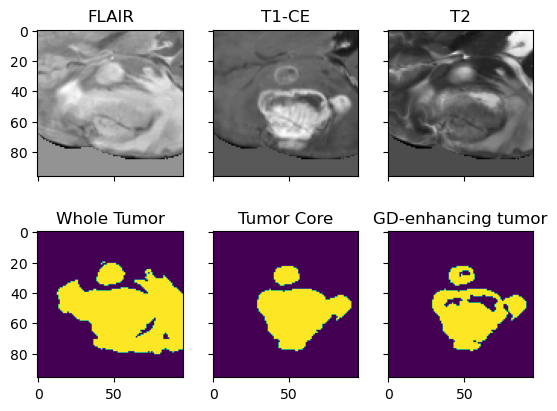

In [20]:
# Visualising the Training Dataset per case

#! Misalignment of Seg and Image Tensors when using Orientationd

patient = 45 # Refers to a folder in the training dataset such as "./MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/"

slice = 40 # Refers to a slice in the 3D Tensor. For visualisation one of the 3 axis must be limited

sample = 0 # multiple random samples are taken per patient

to_plot_case = dataset_training[patient][sample]


fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

ax[0, 0].imshow(to_plot_case["image"][3][:, :, slice], cmap="gray",interpolation = 'antialiased')
ax[0, 0].set_title("FLAIR")

ax[0, 1].imshow(to_plot_case["image"][1][:, :, slice], cmap="gray",interpolation = 'antialiased')
ax[0, 1].set_title("T1-CE")

ax[0, 2].imshow(to_plot_case["image"][2][:, :, slice], cmap="gray",interpolation = 'antialiased')
ax[0, 2].set_title("T2")


ax[1, 0].imshow(to_plot_case["seg"][0][:, :, slice])
ax[1, 0].set_title("Whole Tumor")

ax[1, 1].imshow(to_plot_case["seg"][1][:, :, slice])
ax[1, 1].set_title("Tumor Core")

ax[1, 2].imshow(to_plot_case["seg"][2][:, :, slice])
ax[1, 2].set_title("GD-enhancing tumor")


In [21]:
del(dataset_training)

# Training and Validation of Model

### Preparing the Data Loaders

In [26]:
train_data_loader = DataLoader(
    Dataset(train_cases, transform_training_dataset),
    shuffle=True,
    batch_size=3,
    
)

#! transformation in validation dataset
val_data_loader = DataLoader(
    Dataset(val_cases, transform_validation_dataset),
    shuffle=False,
    batch_size=1,
)


### Initialising the Model and Other Parameters

In [27]:
#! Pure Pytorch Training Loop:
# Ref: https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb
# Ref: https://github.com/Project-MONAI/tutorials/blob/main/2d_segmentation/torch/unet_training_dict.py

clear_gpu_cache()

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
print(f"Training will be done on {device}")

#! Update with proper values
max_epochs = 100
val_interval = 2

model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    strides=(2, 2, 2),
    channels=(12, 24, 48, 96),
    num_res_units=0
).to(device)




initial_lr = 1e-7

optimizer = torch.optim.Adam(model.parameters(), initial_lr, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), initial_lr)

scaler = torch.cuda.amp.GradScaler()

# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=max_epochs, eta_min=1e-8, verbose=True
# )

lr_scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer=optimizer, base_lr=1e-7, mode="triangular2", max_lr=1e-3, cycle_momentum=False, step_size_up=10, gamma=0.1
)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer=optimizer,
#     mode='max',
#     patience=5,
#     verbose=True,
#     threshold=0.01
# )



loss_function = DiceCELoss(sigmoid=True, squared_pred=True)

# loss_function = DiceFocalLoss(sigmoid=True,squared_pred=True,gamma=2)

# ? Check inferer parameters and tweak
def inference(input):
    """Do Sliding Window Inference on input tensor
    To avoid OOM Error, Input Model done on CPU.
    Patch taken from input and its inference done on GPU
    to speed up inference time.

    Args:
        input: Full input to pass in the model. For the case
        of this project size => (3,240,240,155)
    """

    def _compute(input):
        return sliding_window_inference(
            inputs=input.to("cpu"),
            roi_size=(96, 96, 96),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
            padding_mode="constant",
            sw_device="cuda:0",
            device="cpu",
        )

    with torch.cuda.amp.autocast():
        return _compute(input)


post_processing_validation = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)

dice_metric = DiceMetric(include_background=True, reduction="mean")


Deleting Model
Model Already Cleared
Clearing CUDA Cache
Done
Training will be done on cuda:0


### Prepare Folders to Store Model / Load from saved Checkpoint

In [28]:
# ! Set name to False if not loading
NAME_EXPERIMENT = "UNET-DICE-NO_RES-CYCLIC"
# example UNET-2RES-FOCAL_LOSS


training_time = datetime.date(datetime.now()).__str__()

TRAINING_LOG_FILE = f"./checkpoint/{NAME_EXPERIMENT}_{training_time}/training_log.pth"
TRAINING_WEIGHTS_FILE = f"./checkpoint/{NAME_EXPERIMENT}_{training_time}/model_check_point.pth"

try:
    if not os.path.exists(f"./checkpoint/{NAME_EXPERIMENT}_{training_time}"):
        os.makedirs(f"./checkpoint/{NAME_EXPERIMENT}_{training_time}")
except Exception as e:
    pass


try:
    checkpoint = torch.load(TRAINING_WEIGHTS_FILE)

    # load the weights into the model, if the architecture has changed this will not work
    model.load_state_dict(checkpoint["model_state_dict"])

    # load the state of the optimiser, if the optimiser has changed this will not work
    optimizer.load_state_dict(checkpoint["optimiser_state_dict"])

    # load the state of the loss_function class if exists
    loss_function.load_state_dict(checkpoint["loss_function_state_dict"])
except Exception as e:
    checkpoint = {}
    print(e)


try:
    log = torch.load(TRAINING_LOG_FILE)

except Exception as e:
    log = {}
    print(e)


epoch_continue = log.get("epoch", 0)
epoch_loss_values = log.get("loss_per_epoch", [])
metric_values = log.get("dice_metric_per_epoch", [])
best_metric = checkpoint.get("best_metric", -1)
best_metric_epoch = checkpoint.get("best_metric_epoch", 0)


[Errno 2] No such file or directory: './checkpoint/UNET-DICE-NO_RES-CYCLIC_2023-01-19/model_check_point.pth'
[Errno 2] No such file or directory: './checkpoint/UNET-DICE-NO_RES-CYCLIC_2023-01-19/training_log.pth'


In [29]:
print(
    f"Beginning in Training in Folder {NAME_EXPERIMENT}_{training_time}\n\
Log Stored in {NAME_EXPERIMENT}_{training_time}/training_log.pth\n\
Model with best Metric stored in {NAME_EXPERIMENT}_{training_time}/model_check_point.pth"
)






for epoch in range(epoch_continue, max_epochs):
    print("-" * 10)
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in tqdm(train_data_loader):

        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["seg"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        step += 1

    epoch_loss /= step  # average epoch loss

    epoch_loss_values.append(epoch_loss)
    lr_scheduler.step()
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}\n")

    torch.save(
            {
                "epoch": epoch,
                "loss_per_epoch": epoch_loss_values,
                "dice_metric_per_epoch": metric_values,
            },
            TRAINING_LOG_FILE,
        )

    if (epoch + 1) % val_interval == 0:
        print(f"Validating Training at {(epoch + 1)} Epochs")
        model.eval()
        with torch.no_grad():
            for val_data in tqdm(val_data_loader):
                val_inputs, val_labels = (
                    val_data["image"],
                    val_data["seg"].to(device),
                )

                val_outputs = inference(val_inputs)

                val_outputs = [
                    post_processing_validation(i)
                    for i in decollate_batch(val_outputs.to(device))
                ]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            #! Update lr based on metric value
           
            print(f"Learning Rate = {optimizer.param_groups[0]['lr']}")
            # metric_batch = dice_metric_batch.aggregate()
            # metric_tc = metric_batch[0].item()
            # metric_values_tc.append(metric_tc)
            # metric_wt = metric_batch[1].item()
            # metric_values_wt.append(metric_wt)
            # metric_et = metric_batch[2].item()
            # metric_values_et.append(metric_et)
            dice_metric.reset()
            # dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch
                torch.save(
                    {

                        "model_state_dict": model.state_dict(),
                        "optimiser_state_dict": optimizer.state_dict(),
                        "loss_function_state_dict":loss_function.state_dict(),
                        "best_metric": best_metric,
                        "best_metric_epoch": best_metric_epoch,
                    },
                    TRAINING_WEIGHTS_FILE,
                )
                print("saved new best metric model")


            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                # f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch + 1}"
            )

        

Beginning in Training in Folder UNET-DICE-NO_RES-CYCLIC_2023-01-19
Log Stored in UNET-DICE-NO_RES-CYCLIC_2023-01-19/training_log.pth
Model with best Metric stored in UNET-DICE-NO_RES-CYCLIC_2023-01-19/model_check_point.pth
----------
Epoch 1/100


100%|██████████| 99/99 [05:39<00:00,  3.43s/it]


epoch 1 average loss: 1.0479

----------
Epoch 2/100


100%|██████████| 99/99 [05:12<00:00,  3.16s/it]


epoch 2 average loss: 0.9841

Validating Training at 2 Epochs


100%|██████████| 74/74 [07:01<00:00,  5.69s/it]


Learning Rate = 0.00020008000000000019
saved new best metric model
current epoch: 2 current mean dice: 0.0377
best mean dice: 0.0377 at epoch: 2
----------
Epoch 3/100


100%|██████████| 99/99 [05:13<00:00,  3.17s/it]


epoch 3 average loss: 0.8938

----------
Epoch 4/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 4 average loss: 0.8257

Validating Training at 4 Epochs


100%|██████████| 74/74 [06:48<00:00,  5.52s/it]


Learning Rate = 0.0004000599999999999
saved new best metric model
current epoch: 4 current mean dice: 0.1454
best mean dice: 0.1454 at epoch: 4
----------
Epoch 5/100


100%|██████████| 99/99 [05:07<00:00,  3.10s/it]


epoch 5 average loss: 0.7515

----------
Epoch 6/100


100%|██████████| 99/99 [05:12<00:00,  3.15s/it]


epoch 6 average loss: 0.6560

Validating Training at 6 Epochs


100%|██████████| 74/74 [06:55<00:00,  5.61s/it]


Learning Rate = 0.00060004
saved new best metric model
current epoch: 6 current mean dice: 0.3700
best mean dice: 0.3700 at epoch: 6
----------
Epoch 7/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 7 average loss: 0.5441

----------
Epoch 8/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 8 average loss: 0.4619

Validating Training at 8 Epochs


100%|██████████| 74/74 [06:47<00:00,  5.51s/it]


Learning Rate = 0.0008000199999999997
saved new best metric model
current epoch: 8 current mean dice: 0.5936
best mean dice: 0.5936 at epoch: 8
----------
Epoch 9/100


100%|██████████| 99/99 [05:12<00:00,  3.15s/it]


epoch 9 average loss: 0.4226

----------
Epoch 10/100


100%|██████████| 99/99 [05:06<00:00,  3.09s/it]


epoch 10 average loss: 0.3917

Validating Training at 10 Epochs


100%|██████████| 74/74 [06:47<00:00,  5.51s/it]


Learning Rate = 0.001
saved new best metric model
current epoch: 10 current mean dice: 0.6331
best mean dice: 0.6331 at epoch: 10
----------
Epoch 11/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 11 average loss: 0.3749

----------
Epoch 12/100


100%|██████████| 99/99 [05:03<00:00,  3.07s/it]


epoch 12 average loss: 0.3634

Validating Training at 12 Epochs


100%|██████████| 74/74 [06:47<00:00,  5.50s/it]


Learning Rate = 0.0008000199999999997
saved new best metric model
current epoch: 12 current mean dice: 0.6901
best mean dice: 0.6901 at epoch: 12
----------
Epoch 13/100


100%|██████████| 99/99 [05:06<00:00,  3.09s/it]


epoch 13 average loss: 0.3467

----------
Epoch 14/100


100%|██████████| 99/99 [05:12<00:00,  3.15s/it]


epoch 14 average loss: 0.3397

Validating Training at 14 Epochs


100%|██████████| 74/74 [06:56<00:00,  5.63s/it]


Learning Rate = 0.00060004
saved new best metric model
current epoch: 14 current mean dice: 0.6944
best mean dice: 0.6944 at epoch: 14
----------
Epoch 15/100


100%|██████████| 99/99 [05:02<00:00,  3.06s/it]


epoch 15 average loss: 0.3327

----------
Epoch 16/100


100%|██████████| 99/99 [05:04<00:00,  3.07s/it]


epoch 16 average loss: 0.3274

Validating Training at 16 Epochs


100%|██████████| 74/74 [06:48<00:00,  5.52s/it]


Learning Rate = 0.0004000599999999999
saved new best metric model
current epoch: 16 current mean dice: 0.7507
best mean dice: 0.7507 at epoch: 16
----------
Epoch 17/100


100%|██████████| 99/99 [05:11<00:00,  3.15s/it]


epoch 17 average loss: 0.3189

----------
Epoch 18/100


100%|██████████| 99/99 [05:13<00:00,  3.16s/it]


epoch 18 average loss: 0.3160

Validating Training at 18 Epochs


100%|██████████| 74/74 [06:48<00:00,  5.52s/it]


Learning Rate = 0.00020008000000000019
saved new best metric model
current epoch: 18 current mean dice: 0.7676
best mean dice: 0.7676 at epoch: 18
----------
Epoch 19/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 19 average loss: 0.3075

----------
Epoch 20/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 20 average loss: 0.3033

Validating Training at 20 Epochs


100%|██████████| 74/74 [06:52<00:00,  5.57s/it]


Learning Rate = 1e-07
current epoch: 20 current mean dice: 0.7533
best mean dice: 0.7676 at epoch: 18
----------
Epoch 21/100


100%|██████████| 99/99 [05:12<00:00,  3.16s/it]


epoch 21 average loss: 0.3003

----------
Epoch 22/100


100%|██████████| 99/99 [05:12<00:00,  3.16s/it]


epoch 22 average loss: 0.3001

Validating Training at 22 Epochs


100%|██████████| 74/74 [06:48<00:00,  5.52s/it]


Learning Rate = 0.0001000900000000001
current epoch: 22 current mean dice: 0.7513
best mean dice: 0.7676 at epoch: 18
----------
Epoch 23/100


100%|██████████| 99/99 [05:13<00:00,  3.16s/it]


epoch 23 average loss: 0.3018

----------
Epoch 24/100


100%|██████████| 99/99 [05:12<00:00,  3.15s/it]


epoch 24 average loss: 0.3008

Validating Training at 24 Epochs


100%|██████████| 74/74 [06:48<00:00,  5.52s/it]


Learning Rate = 0.00020008000000000019
current epoch: 24 current mean dice: 0.7565
best mean dice: 0.7676 at epoch: 18
----------
Epoch 25/100


100%|██████████| 99/99 [05:14<00:00,  3.18s/it]


epoch 25 average loss: 0.3009

----------
Epoch 26/100


100%|██████████| 99/99 [05:16<00:00,  3.20s/it]


epoch 26 average loss: 0.3010

Validating Training at 26 Epochs


100%|██████████| 74/74 [06:56<00:00,  5.63s/it]


Learning Rate = 0.00030006999999999983
current epoch: 26 current mean dice: 0.7388
best mean dice: 0.7676 at epoch: 18
----------
Epoch 27/100


100%|██████████| 99/99 [05:15<00:00,  3.18s/it]


epoch 27 average loss: 0.3029

----------
Epoch 28/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 28 average loss: 0.2998

Validating Training at 28 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 0.0004000599999999999
current epoch: 28 current mean dice: 0.7629
best mean dice: 0.7676 at epoch: 18
----------
Epoch 29/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 29 average loss: 0.2981

----------
Epoch 30/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 30 average loss: 0.2990

Validating Training at 30 Epochs


100%|██████████| 74/74 [06:55<00:00,  5.62s/it]


Learning Rate = 0.0005000499999999999
saved new best metric model
current epoch: 30 current mean dice: 0.7727
best mean dice: 0.7727 at epoch: 30
----------
Epoch 31/100


100%|██████████| 99/99 [05:07<00:00,  3.11s/it]


epoch 31 average loss: 0.3028

----------
Epoch 32/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 32 average loss: 0.2927

Validating Training at 32 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.54s/it]


Learning Rate = 0.0004000599999999999
current epoch: 32 current mean dice: 0.7504
best mean dice: 0.7727 at epoch: 30
----------
Epoch 33/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 33 average loss: 0.2914

----------
Epoch 34/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 34 average loss: 0.2893

Validating Training at 34 Epochs


100%|██████████| 74/74 [06:48<00:00,  5.52s/it]


Learning Rate = 0.00030006999999999983
saved new best metric model
current epoch: 34 current mean dice: 0.7815
best mean dice: 0.7815 at epoch: 34
----------
Epoch 35/100


100%|██████████| 99/99 [05:03<00:00,  3.07s/it]


epoch 35 average loss: 0.2876

----------
Epoch 36/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 36 average loss: 0.2857

Validating Training at 36 Epochs


100%|██████████| 74/74 [06:48<00:00,  5.53s/it]


Learning Rate = 0.00020008000000000019
current epoch: 36 current mean dice: 0.7550
best mean dice: 0.7815 at epoch: 34
----------
Epoch 37/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 37 average loss: 0.2802

----------
Epoch 38/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 38 average loss: 0.2784

Validating Training at 38 Epochs


100%|██████████| 74/74 [06:50<00:00,  5.55s/it]


Learning Rate = 0.0001000900000000001
current epoch: 38 current mean dice: 0.7728
best mean dice: 0.7815 at epoch: 34
----------
Epoch 39/100


100%|██████████| 99/99 [05:17<00:00,  3.20s/it]


epoch 39 average loss: 0.2786

----------
Epoch 40/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 40 average loss: 0.2755

Validating Training at 40 Epochs


100%|██████████| 74/74 [06:50<00:00,  5.55s/it]


Learning Rate = 1e-07
current epoch: 40 current mean dice: 0.7779
best mean dice: 0.7815 at epoch: 34
----------
Epoch 41/100


100%|██████████| 99/99 [05:06<00:00,  3.10s/it]


epoch 41 average loss: 0.2743

----------
Epoch 42/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 42 average loss: 0.2751

Validating Training at 42 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 5.009500000000005e-05
current epoch: 42 current mean dice: 0.7798
best mean dice: 0.7815 at epoch: 34
----------
Epoch 43/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 43 average loss: 0.2786

----------
Epoch 44/100


100%|██████████| 99/99 [05:06<00:00,  3.09s/it]


epoch 44 average loss: 0.2750

Validating Training at 44 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.54s/it]


Learning Rate = 0.0001000900000000001
current epoch: 44 current mean dice: 0.7783
best mean dice: 0.7815 at epoch: 34
----------
Epoch 45/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 45 average loss: 0.2745

----------
Epoch 46/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 46 average loss: 0.2759

Validating Training at 46 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 0.00015008499999999992
current epoch: 46 current mean dice: 0.7702
best mean dice: 0.7815 at epoch: 34
----------
Epoch 47/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 47 average loss: 0.2765

----------
Epoch 48/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 48 average loss: 0.2763

Validating Training at 48 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 0.00020007999999999994
current epoch: 48 current mean dice: 0.7799
best mean dice: 0.7815 at epoch: 34
----------
Epoch 49/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 49 average loss: 0.2744

----------
Epoch 50/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 50 average loss: 0.2777

Validating Training at 50 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 0.000250075
current epoch: 50 current mean dice: 0.7708
best mean dice: 0.7815 at epoch: 34
----------
Epoch 51/100


100%|██████████| 99/99 [05:04<00:00,  3.07s/it]


epoch 51 average loss: 0.2748

----------
Epoch 52/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 52 average loss: 0.2751

Validating Training at 52 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 0.00020007999999999994
current epoch: 52 current mean dice: 0.7626
best mean dice: 0.7815 at epoch: 34
----------
Epoch 53/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 53 average loss: 0.2740

----------
Epoch 54/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 54 average loss: 0.2721

Validating Training at 54 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 0.00015008499999999992
saved new best metric model
current epoch: 54 current mean dice: 0.7844
best mean dice: 0.7844 at epoch: 54
----------
Epoch 55/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 55 average loss: 0.2717

----------
Epoch 56/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 56 average loss: 0.2692

Validating Training at 56 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.54s/it]


Learning Rate = 0.0001000900000000001
current epoch: 56 current mean dice: 0.7800
best mean dice: 0.7844 at epoch: 54
----------
Epoch 57/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 57 average loss: 0.2669

----------
Epoch 58/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 58 average loss: 0.2673

Validating Training at 58 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 5.009500000000005e-05
saved new best metric model
current epoch: 58 current mean dice: 0.7848
best mean dice: 0.7848 at epoch: 58
----------
Epoch 59/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 59 average loss: 0.2679

----------
Epoch 60/100


100%|██████████| 99/99 [05:04<00:00,  3.07s/it]


epoch 60 average loss: 0.2652

Validating Training at 60 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.54s/it]


Learning Rate = 1e-07
current epoch: 60 current mean dice: 0.7791
best mean dice: 0.7848 at epoch: 58
----------
Epoch 61/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 61 average loss: 0.2644

----------
Epoch 62/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 62 average loss: 0.2654

Validating Training at 62 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.54s/it]


Learning Rate = 2.509749999999991e-05
current epoch: 62 current mean dice: 0.7817
best mean dice: 0.7848 at epoch: 58
----------
Epoch 63/100


100%|██████████| 99/99 [05:03<00:00,  3.07s/it]


epoch 63 average loss: 0.2645

----------
Epoch 64/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 64 average loss: 0.2655

Validating Training at 64 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.54s/it]


Learning Rate = 5.009500000000005e-05
current epoch: 64 current mean dice: 0.7826
best mean dice: 0.7848 at epoch: 58
----------
Epoch 65/100


100%|██████████| 99/99 [05:06<00:00,  3.09s/it]


epoch 65 average loss: 0.2650

----------
Epoch 66/100


100%|██████████| 99/99 [05:06<00:00,  3.10s/it]


epoch 66 average loss: 0.2661

Validating Training at 66 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 7.509249999999996e-05
saved new best metric model
current epoch: 66 current mean dice: 0.7872
best mean dice: 0.7872 at epoch: 66
----------
Epoch 67/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 67 average loss: 0.2669

----------
Epoch 68/100


100%|██████████| 99/99 [05:06<00:00,  3.09s/it]


epoch 68 average loss: 0.2680

Validating Training at 68 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 0.0001000900000000001
current epoch: 68 current mean dice: 0.7812
best mean dice: 0.7872 at epoch: 66
----------
Epoch 69/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 69 average loss: 0.2683

----------
Epoch 70/100


100%|██████████| 99/99 [05:06<00:00,  3.10s/it]


epoch 70 average loss: 0.2663

Validating Training at 70 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.54s/it]


Learning Rate = 0.0001250875
current epoch: 70 current mean dice: 0.7764
best mean dice: 0.7872 at epoch: 66
----------
Epoch 71/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 71 average loss: 0.2664

----------
Epoch 72/100


100%|██████████| 99/99 [05:07<00:00,  3.10s/it]


epoch 72 average loss: 0.2674

Validating Training at 72 Epochs


100%|██████████| 74/74 [06:51<00:00,  5.55s/it]


Learning Rate = 0.0001000900000000001
current epoch: 72 current mean dice: 0.7822
best mean dice: 0.7872 at epoch: 66
----------
Epoch 73/100


100%|██████████| 99/99 [05:07<00:00,  3.10s/it]


epoch 73 average loss: 0.2662

----------
Epoch 74/100


100%|██████████| 99/99 [05:12<00:00,  3.15s/it]


epoch 74 average loss: 0.2639

Validating Training at 74 Epochs


100%|██████████| 74/74 [06:51<00:00,  5.56s/it]


Learning Rate = 7.509249999999996e-05
saved new best metric model
current epoch: 74 current mean dice: 0.7875
best mean dice: 0.7875 at epoch: 74
----------
Epoch 75/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 75 average loss: 0.2622

----------
Epoch 76/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 76 average loss: 0.2649

Validating Training at 76 Epochs


100%|██████████| 74/74 [06:50<00:00,  5.54s/it]


Learning Rate = 5.009500000000005e-05
current epoch: 76 current mean dice: 0.7808
best mean dice: 0.7875 at epoch: 74
----------
Epoch 77/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 77 average loss: 0.2622

----------
Epoch 78/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 78 average loss: 0.2615

Validating Training at 78 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 2.509749999999991e-05
current epoch: 78 current mean dice: 0.7793
best mean dice: 0.7875 at epoch: 74
----------
Epoch 79/100


100%|██████████| 99/99 [05:06<00:00,  3.09s/it]


epoch 79 average loss: 0.2608

----------
Epoch 80/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 80 average loss: 0.2599

Validating Training at 80 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 1e-07
current epoch: 80 current mean dice: 0.7840
best mean dice: 0.7875 at epoch: 74
----------
Epoch 81/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 81 average loss: 0.2597

----------
Epoch 82/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 82 average loss: 0.2589

Validating Training at 82 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 1.2598749999999956e-05
current epoch: 82 current mean dice: 0.7838
best mean dice: 0.7875 at epoch: 74
----------
Epoch 83/100


100%|██████████| 99/99 [05:03<00:00,  3.06s/it]


epoch 83 average loss: 0.2595

----------
Epoch 84/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 84 average loss: 0.2610

Validating Training at 84 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 2.5097500000000022e-05
current epoch: 84 current mean dice: 0.7836
best mean dice: 0.7875 at epoch: 74
----------
Epoch 85/100


100%|██████████| 99/99 [05:04<00:00,  3.08s/it]


epoch 85 average loss: 0.2616

----------
Epoch 86/100


100%|██████████| 99/99 [05:03<00:00,  3.07s/it]


epoch 86 average loss: 0.2607

Validating Training at 86 Epochs


100%|██████████| 74/74 [06:48<00:00,  5.52s/it]


Learning Rate = 3.759624999999998e-05
current epoch: 86 current mean dice: 0.7737
best mean dice: 0.7875 at epoch: 74
----------
Epoch 87/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 87 average loss: 0.2603

----------
Epoch 88/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 88 average loss: 0.2602

Validating Training at 88 Epochs


100%|██████████| 74/74 [06:48<00:00,  5.53s/it]


Learning Rate = 5.009500000000005e-05
current epoch: 88 current mean dice: 0.7844
best mean dice: 0.7875 at epoch: 74
----------
Epoch 89/100


100%|██████████| 99/99 [05:06<00:00,  3.10s/it]


epoch 89 average loss: 0.2613

----------
Epoch 90/100


100%|██████████| 99/99 [05:04<00:00,  3.07s/it]


epoch 90 average loss: 0.2596

Validating Training at 90 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 6.259375e-05
current epoch: 90 current mean dice: 0.7869
best mean dice: 0.7875 at epoch: 74
----------
Epoch 91/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 91 average loss: 0.2601

----------
Epoch 92/100


100%|██████████| 99/99 [05:04<00:00,  3.07s/it]


epoch 92 average loss: 0.2603

Validating Training at 92 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 5.009500000000005e-05
saved new best metric model
current epoch: 92 current mean dice: 0.7898
best mean dice: 0.7898 at epoch: 92
----------
Epoch 93/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 93 average loss: 0.2604

----------
Epoch 94/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 94 average loss: 0.2589

Validating Training at 94 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 3.759624999999998e-05
current epoch: 94 current mean dice: 0.7802
best mean dice: 0.7898 at epoch: 92
----------
Epoch 95/100


100%|██████████| 99/99 [05:04<00:00,  3.07s/it]


epoch 95 average loss: 0.2614

----------
Epoch 96/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 96 average loss: 0.2597

Validating Training at 96 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 2.5097500000000022e-05
current epoch: 96 current mean dice: 0.7830
best mean dice: 0.7898 at epoch: 92
----------
Epoch 97/100


100%|██████████| 99/99 [05:04<00:00,  3.07s/it]


epoch 97 average loss: 0.2583

----------
Epoch 98/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 98 average loss: 0.2592

Validating Training at 98 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]


Learning Rate = 1.2598749999999956e-05
current epoch: 98 current mean dice: 0.7805
best mean dice: 0.7898 at epoch: 92
----------
Epoch 99/100


100%|██████████| 99/99 [05:05<00:00,  3.08s/it]


epoch 99 average loss: 0.2575

----------
Epoch 100/100


100%|██████████| 99/99 [05:05<00:00,  3.09s/it]


epoch 100 average loss: 0.2578

Validating Training at 100 Epochs


100%|██████████| 74/74 [06:49<00:00,  5.53s/it]

Learning Rate = 1e-07
current epoch: 100 current mean dice: 0.7845
best mean dice: 0.7898 at epoch: 92


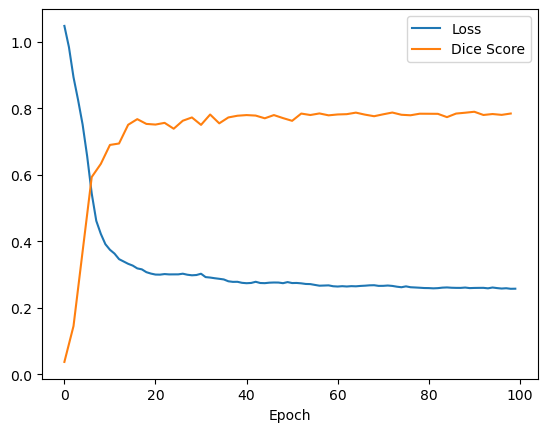

In [34]:
fig = plt.axes()
fig.plot(epoch_loss_values,label="Loss")
fig.plot([x*2 for x in range(len(metric_values))],metric_values,label="Dice Score")
fig.set_xlabel("Epoch")
fig.legend()

In [ ]:
lr_scheduler.get_last_lr()

[0.000107837788809226]

In [ ]:
clear_gpu_cache()

Deleting Model
Clearing CUDA Cache
Done
